# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from src.utils import *
from src.agentDDPG import Agent

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env_name = '20-agents'

env = UnityEnvironment(file_name="env/{}/Reacher.exe".format(env_name))

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


# DDGP

In [5]:
#Create Agent and Set Parameters
agent = Agent(state_size, action_size, random_seed=0, hidden_layers = [164,128])

In [6]:
def ddpg():
    scores_window_100 = deque(maxlen=100)
    scores_window_300 = deque(maxlen=300)
    

    agent_scores = []
    scores_moving_avg_100 = []
    scores_moving_avg_300 = []
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        states = env_info.vector_observations       
        agent.reset()
        scores = np.zeros(num_agents) 
        for t in range(max_t):
            actions = agent.act(states, add_noise=True)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations   # get the next state
            rewards = env_info.rewards                   # get the reward
            dones = env_info.local_done 
            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, i_episode, done)    
            states = next_states
            scores += rewards
            if np.any(dones):
                break 
            
        agent_scores.append(np.mean(scores)) 
        scores_window_100.append(agent_scores[-1]) 
        scores_window_300.append(agent_scores[-1]) 
        scores_moving_avg_100.append(np.mean(scores_window_100))
        scores_moving_avg_300.append(np.mean(scores_window_300))
        
        print('\rEpisode {}\tAvg Score (Last 100 eps): {:.2f}\tAvg Score (Last 300 eps): {:.2f}\tScore: {:.2f}'.format(i_episode, scores_moving_avg_100[-1],scores_moving_avg_300[-1], agent_scores[-1]), end="")
        if i_episode % 10 == 0:
            print('\nEpisode {}\tAverage Score: {:.2f}'.format(i_episode, scores_moving_avg_100[-1]))
            
            fig = plt.figure(figsize=(12, 10))
            ax = fig.add_subplot(111)
            plt.plot(agent_scores, label='Scores')
            plt.plot(scores_moving_avg_100, label='Average Scores (Last 100 episodes)')
            plt.plot(scores_moving_avg_300, label='Average Scores (Last 300 episodes)')
            plt.ylabel('Score')
            plt.xlabel('Episode #')
            plt.legend(loc='upper left');
            plt.grid()
            fig.savefig('results/scores_{}.png'.format(env_name))
            plt.show()
            
        if scores_moving_avg_100[-1] >= TARGET_SCORE:
            print("Final score windows: {}".format(scores_moving_avg_100[-1]))
            
            # Save models
            torch.save(agent.actor_local.state_dict(), 'models/{}/checkpoint_actor.pth'.format(env_name))
            torch.save(agent.critic_local.state_dict(),'models/{}/checkpoint_critic.pth'.format(env_name))
            # Save results
            np.savetxt('results/{}/scores.txt'.format(env_name), (scores), fmt='%05d')
            np.savetxt('results/{}/scores_moving100.txt'.format(env_name), (scores_moving_avg_100), fmt='%05d')
            np.savetxt('results/{}/scores_moving300.txt'.format(env_name), (scores_moving_avg_300), fmt='%05d')

            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, scores_moving_avg_100[-1]))
            break
    return agent_scores, scores_moving_avg_100, scores_moving_avg_300

c:\users\fernando\anaconda3\envs\udacity\lib\site-packages\torch\nn\functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 10	Avg Score (Last 100 eps): 2.73	Avg Score (Last 300 eps): 2.73	Score: 5.36
Episode 10	Average Score: 2.73


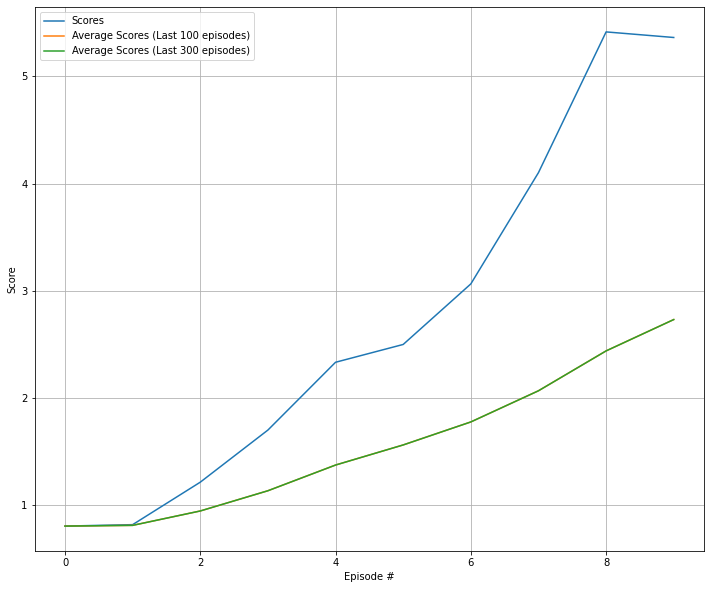

Episode 20	Avg Score (Last 100 eps): 5.73	Avg Score (Last 300 eps): 5.73	Score: 10.87
Episode 20	Average Score: 5.73


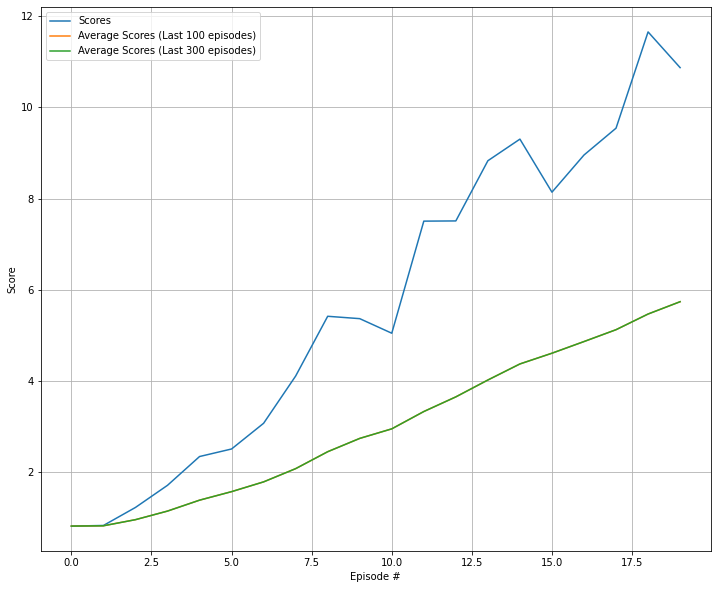

Episode 30	Avg Score (Last 100 eps): 11.88	Avg Score (Last 300 eps): 11.88	Score: 29.05
Episode 30	Average Score: 11.88


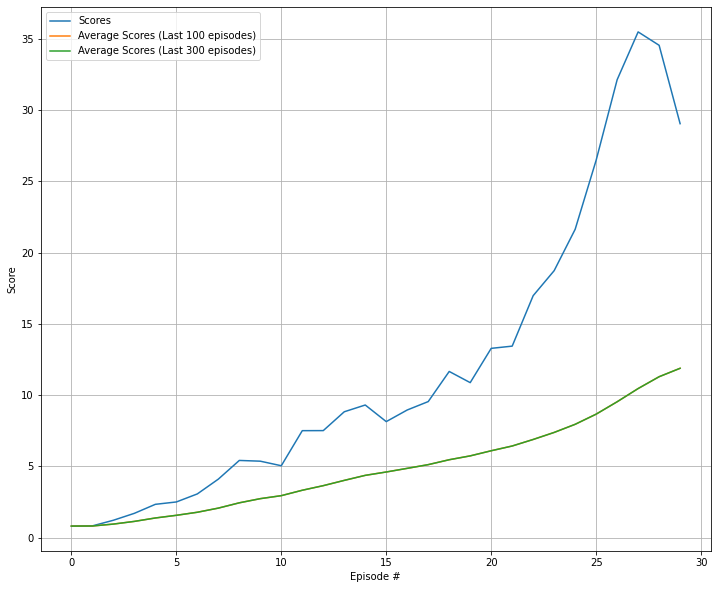

Episode 40	Avg Score (Last 100 eps): 17.11	Avg Score (Last 300 eps): 17.11	Score: 33.89
Episode 40	Average Score: 17.11


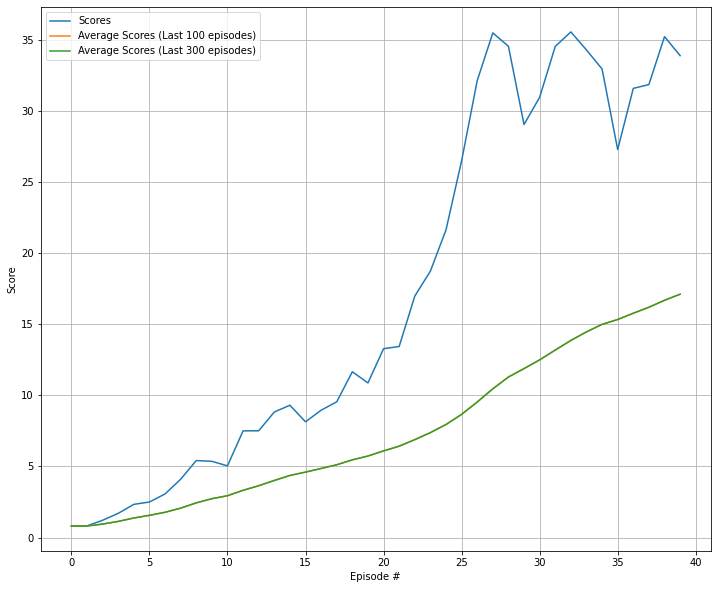

Episode 50	Avg Score (Last 100 eps): 20.29	Avg Score (Last 300 eps): 20.29	Score: 34.82
Episode 50	Average Score: 20.29


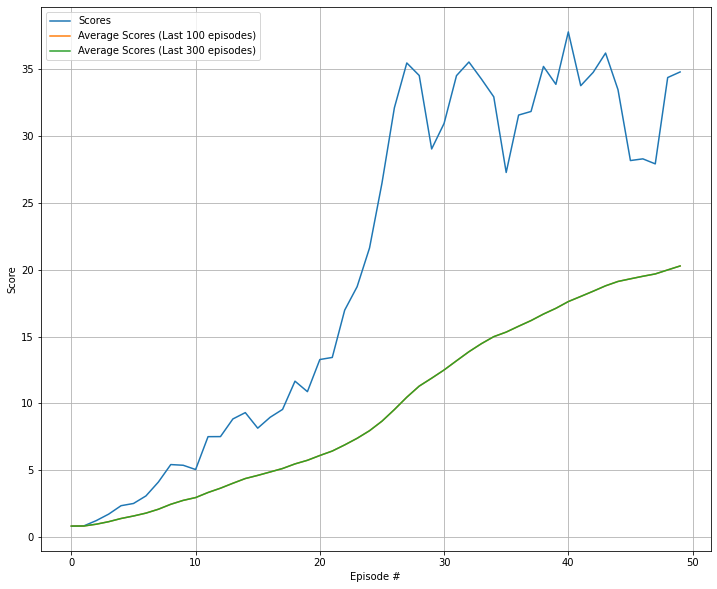

Episode 60	Avg Score (Last 100 eps): 22.62	Avg Score (Last 300 eps): 22.62	Score: 35.31
Episode 60	Average Score: 22.62


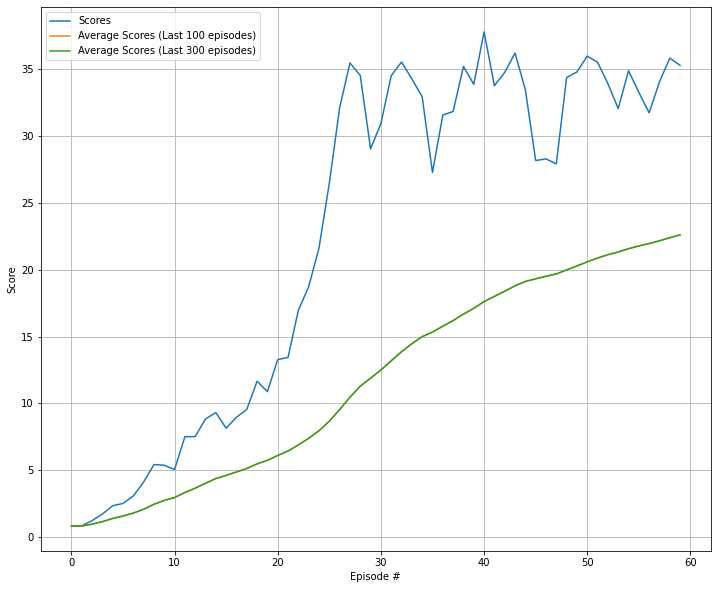

Episode 70	Avg Score (Last 100 eps): 24.08	Avg Score (Last 300 eps): 24.08	Score: 35.18
Episode 70	Average Score: 24.08


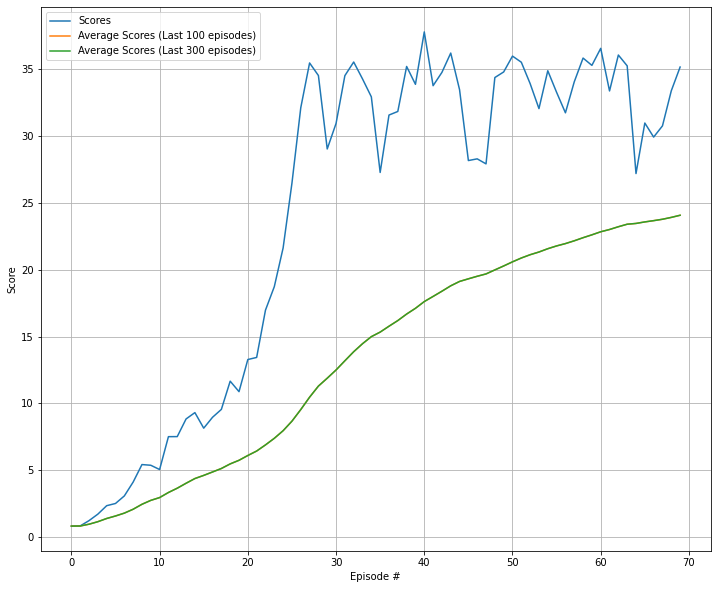

Episode 80	Avg Score (Last 100 eps): 25.21	Avg Score (Last 300 eps): 25.21	Score: 31.18
Episode 80	Average Score: 25.21


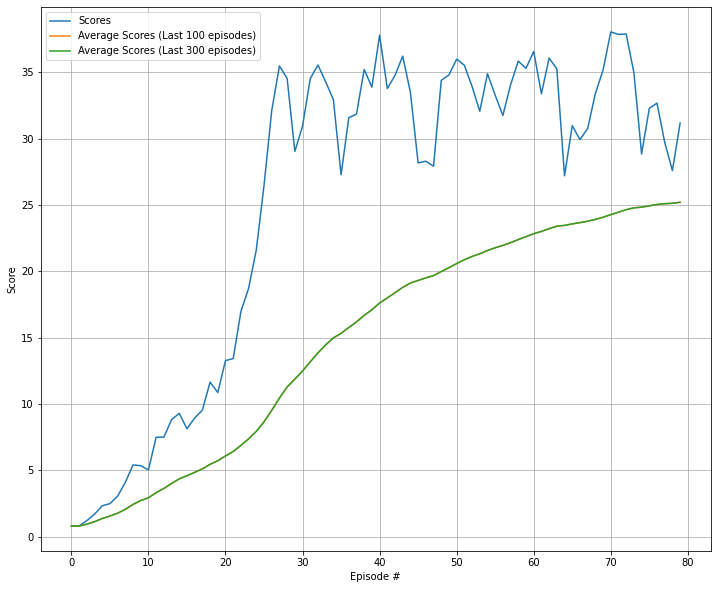

Episode 90	Avg Score (Last 100 eps): 26.18	Avg Score (Last 300 eps): 26.18	Score: 35.72
Episode 90	Average Score: 26.18


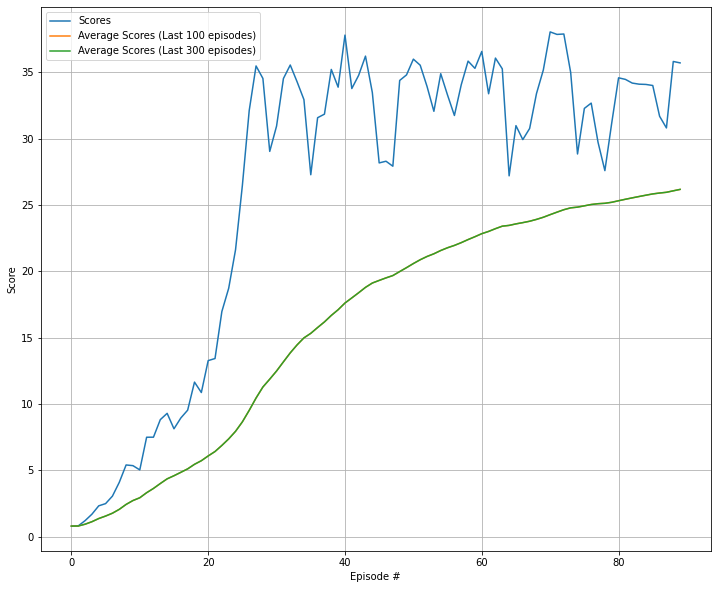

Episode 100	Avg Score (Last 100 eps): 26.90	Avg Score (Last 300 eps): 26.90	Score: 35.63
Episode 100	Average Score: 26.90


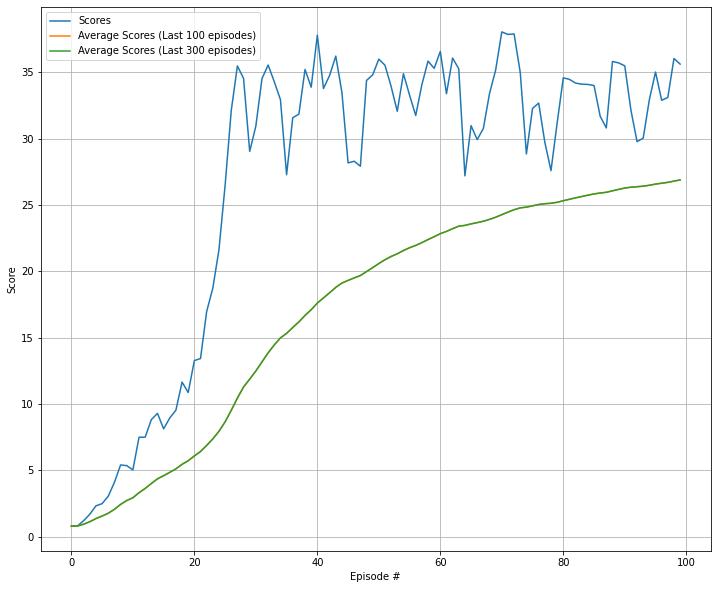

Episode 110	Avg Score (Last 100 eps): 29.90	Avg Score (Last 300 eps): 27.43	Score: 34.07
Episode 110	Average Score: 29.90


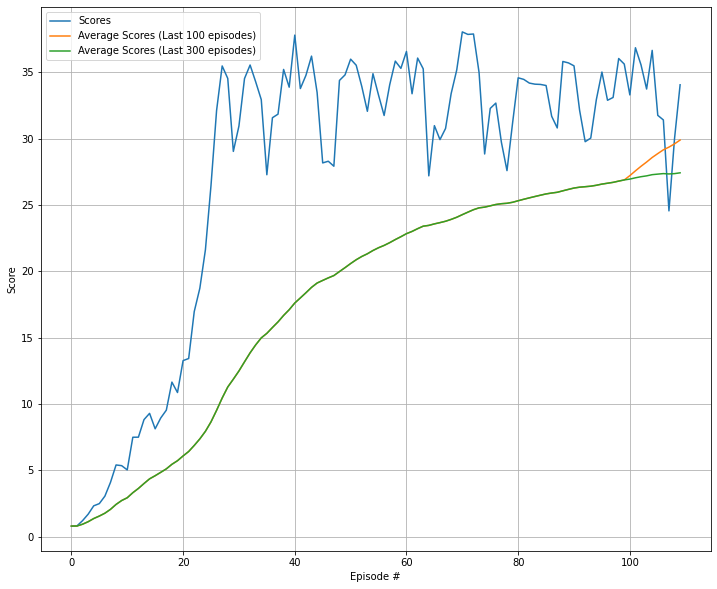

Episode 111	Avg Score (Last 100 eps): 30.21	Avg Score (Last 300 eps): 27.51	Score: 35.35Final score windows: 30.20749432480987

Environment solved in 11 episodes!	Average Score: 30.21


In [7]:
scores, scores_mean_100, scores_mean_300 = ddpg()

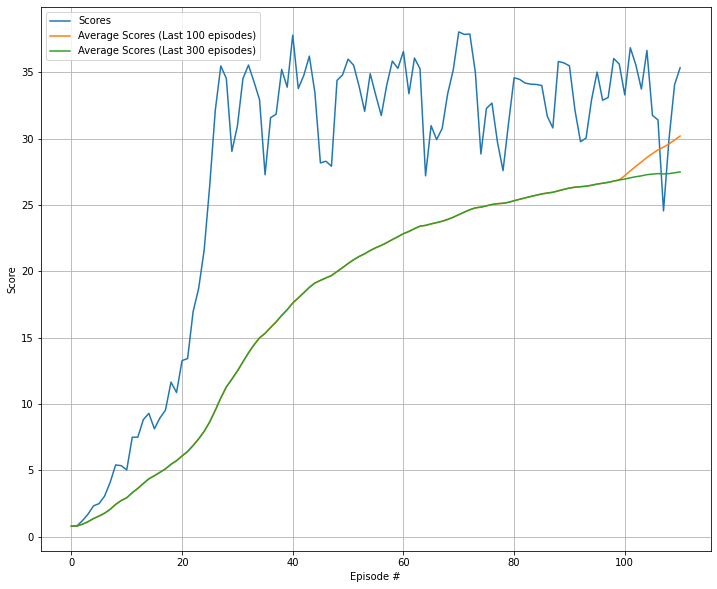

In [9]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111)
plt.plot(scores, label='Scores')
plt.plot(scores_mean_100, label='Average Scores (Last 100 episodes)')
plt.plot(scores_mean_300, label='Average Scores (Last 300 episodes)')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left');
plt.grid()
fig.savefig('results/final_scores_{}.png'.format(env_name))
plt.show()

In [10]:
env.close()

ERROR:root:Exception calling application: 
Traceback (most recent call last):
  File "c:\users\fernando\anaconda3\envs\udacity\lib\multiprocessing\connection.py", line 312, in _recv_bytes
    nread, err = ov.GetOverlappedResult(True)
BrokenPipeError: [WinError 109] Ha terminado la canalización

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\users\fernando\anaconda3\envs\udacity\lib\site-packages\grpc\_server.py", line 385, in _call_behavior
    return behavior(argument, context), True
  File "c:\users\fernando\anaconda3\envs\udacity\lib\site-packages\unityagents\rpc_communicator.py", line 26, in Exchange
    return self.child_conn.recv()
  File "c:\users\fernando\anaconda3\envs\udacity\lib\multiprocessing\connection.py", line 250, in recv
    buf = self._recv_bytes()
  File "c:\users\fernando\anaconda3\envs\udacity\lib\multiprocessing\connection.py", line 321, in _recv_bytes
    raise EOFError
EOFError


In [ ]:
scores_mean_100[-1] >= TARGET_SCORE

In [ ]:
STOP

In [ ]:
scores = np.loadtxt('results/scores_1_[1.00999998]_0.6799999848008156.txt', delimiter='\n')
scores_mean = np.loadtxt('results/scores_moving_1_[1.00999998]_0.6799999848008156.txt', delimiter='\n')

In [ ]:
plt.plot(scores)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='Scores')
plt.plot(np.arange(len(scores)), scores_mean, c='b', label='Average Scores')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left');
plt.show()

In [ ]:
np.savetxt('score.txt',scores)

In [ ]:
np.savetxt('av_score.txt',scores_mean)

In [ ]:
env.close()